# Bitcoin Prediction Using ARIMA and RNN-LSTM
## Please refer to the project report for details on results and observations

## Setup

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
import datetime
import pandas as pd

#from keras.models import Sequential

#from keras.layers import Dense, Activation

import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.tabular import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
coinbase=pd.read_csv('ltc_clean_2.csv')

## Data Exploration

In [70]:
from datetime import datetime

def timestampToDateTime(timestamp):
    return datetime.fromtimestamp(timestamp)
#Not needed for our data since we already have it in date.
#coinbase['DateTime']=coinbase['Date'].apply(timestampToDateTime)

coinbase['DateTime'] = pd.to_datetime(coinbase['Date'])
coinbase.dtypes

Date                   object
Open                  float64
High                  float64
Low                   float64
Close                 float64
Adj Close             float64
Volume                float64
GDP                   float64
inflation             float64
MoneySupply           float64
DateTime       datetime64[ns]
dtype: object

In [71]:
(coinbase.head())

,Date,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime
0,2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840.0,1.752720e+13,1.849827,11931.5,2014-09-17
1,2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260.0,1.752720e+13,1.849827,11931.5,2014-09-18
2,2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450.0,1.752720e+13,1.849827,11931.5,2014-09-19
3,2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660.0,1.752720e+13,1.849827,11931.5,2014-09-20
4,2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220.0,1.752720e+13,1.849827,11931.5,2014-09-21


Let's get rid of the timestamp Now

In [72]:
coinbase.drop('Date',axis=1,inplace=True) 

Let's verify if everything looks good

In [73]:
(coinbase.head())

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime
0,5.08589,5.17077,4.96595,5.05855,5.05855,3071840.0,1.752720e+13,1.849827,11931.5,2014-09-17
1,5.06543,5.06543,4.57996,4.68523,4.68523,4569260.0,1.752720e+13,1.849827,11931.5,2014-09-18
2,4.68729,4.75582,4.25435,4.32777,4.32777,3917450.0,1.752720e+13,1.849827,11931.5,2014-09-19
3,4.32920,4.61608,4.20219,4.28644,4.28644,5490660.0,1.752720e+13,1.849827,11931.5,2014-09-20
4,4.26307,4.30013,4.15499,4.24592,4.24592,2931220.0,1.752720e+13,1.849827,11931.5,2014-09-21


In [74]:
(coinbase[coinbase['DateTime']=='2016'])

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime
471,3.47952,3.53102,3.46925,3.50898,3.50898,2791170.0,1.871500e+13,1.035269,12355.3,2016-01-01


In [75]:
timeindex=pd.DatetimeIndex(coinbase['DateTime'])

In [76]:
coinbase.set_index(timeindex, inplace=True)

In [77]:
(coinbase['2016'].head())

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime
DateTime,,,,,,,,,,
2016-01-01,3.47952,3.53102,3.46925,3.50898,3.50898,2791170.0,1.871500e+13,1.035269,12355.3,2016-01-01
2016-01-02,3.51528,3.52712,3.49219,3.50216,3.50216,3020260.0,1.871500e+13,1.035269,12355.3,2016-01-02
2016-01-03,3.50400,3.50643,3.45086,3.48307,3.48307,2406150.0,1.871500e+13,1.035269,12355.3,2016-01-03
2016-01-04,3.47910,3.50723,3.47615,3.49539,3.49539,3309740.0,1.871500e+13,1.035269,12355.3,2016-01-04
2016-01-05,3.49200,3.50819,3.45372,3.46967,3.46967,2104650.0,1.871500e+13,1.035269,12454.7,2016-01-05


<AxesSubplot:xlabel='DateTime'>

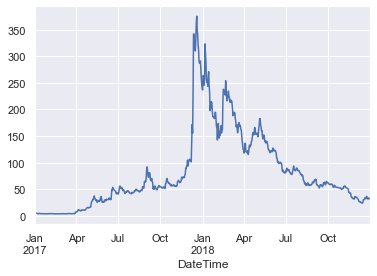

In [19]:
#sns.set(style="darkgrid")
import seaborn as sns; sns.set()
#sns.lineplot(x="Date", y="Close",
#             data=coinbase)

coinbase['2017':'2018']['High'].plot()

#coinbase['2017':'2018']['High'].resample(rule='T').plot()



DateTime
2017-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2017-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
2017-09-29    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: BM, Name: High, dtype: object

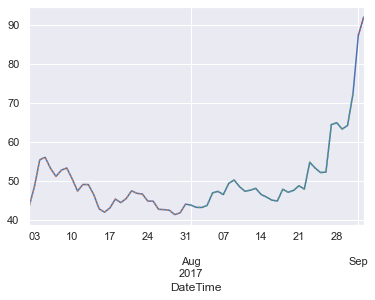

In [20]:
data=coinbase['2017-07-02':'2017-09-02']
data['High'].plot(style="-")
data['High'].resample('BM').plot(style=":")

In [24]:
coinbase['PriceClose2D']=coinbase['Close']

In [25]:
shift=2 #  days
coinbase['PriceClose2D']=coinbase['PriceClose2D'].shift(-shift)
coinbase=coinbase[:-shift]

In [26]:
coinbase[73:90]

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime,PriceClose2D
DateTime,,,,,,,,,,,
2014-11-29,3.60471,3.63612,3.57032,3.58628,3.58628,2264640.0,1.752720e+13,1.849827,11931.5,2014-11-29,3.57714
2014-11-30,3.58596,3.61412,3.56247,3.57609,3.57609,1206290.0,1.752720e+13,1.849827,11931.5,2014-11-30,3.63110
2014-12-01,3.57559,3.60692,3.56664,3.57714,3.57714,1275120.0,1.752720e+13,1.849827,11931.5,2014-12-01,3.61202
2014-12-02,3.57799,3.66159,3.57779,3.63110,3.63110,2051950.0,1.752720e+13,1.849827,11931.5,2014-12-02,3.59263
2014-12-03,3.62800,3.65285,3.58207,3.61202,3.61202,1715450.0,1.752720e+13,1.849827,11931.5,2014-12-03,3.61823
2014-12-04,3.61170,3.63680,3.58622,3.59263,3.59263,2291670.0,1.752720e+13,1.849827,11931.5,2014-12-04,3.61452
2014-12-05,3.59409,3.62251,3.57577,3.61823,3.61823,2350920.0,1.752720e+13,1.849827,11931.5,2014-12-05,3.71116
2014-12-06,3.61596,3.62823,3.60367,3.61452,3.61452,1690520.0,1.752720e+13,1.849827,11931.5,2014-12-06,3.65320
2014-12-07,3.61560,3.74953,3.60851,3.71116,3.71116,1759240.0,1.752720e+13,1.849827,11931.5,2014-12-07,3.52117


In [27]:
#Add_Datepart no longer in fastai but implementation found at: https://github.com/fastai/fastai_old/blob/master/dev_nb/x_009a_rossman_data_clean.ipynb
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [28]:
#add_datepart(coinbase,'DateTime')

In [29]:
coinbase['2015']

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime,PriceClose2D
DateTime,,,,,,,,,,,
2015-01-01,2.72421,2.72421,2.68977,2.69905,2.69905,770693.0,1.822470e+13,1.041462,11931.5,2015-01-01,2.13316
2015-01-02,2.69743,2.69924,2.66385,2.66736,2.66736,855392.0,1.822470e+13,1.041462,11931.5,2015-01-02,1.95668
2015-01-03,2.66646,2.66646,2.13316,2.13316,2.13316,5193080.0,1.822470e+13,1.041462,11931.5,2015-01-03,2.08218
2015-01-04,2.11022,2.15446,1.91241,1.95668,1.95668,3888140.0,1.822470e+13,1.041462,11931.5,2015-01-04,2.11212
2015-01-05,1.95803,2.16048,1.95803,2.08218,2.08218,10649500.0,1.822470e+13,1.041462,11931.5,2015-01-05,2.11818
...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,3.42032,3.49249,3.39342,3.47905,3.47905,2048800.0,1.822470e+13,1.041462,12368.6,2015-12-27,3.50026
2015-12-28,3.47781,3.52972,3.45675,3.46603,3.46603,1647170.0,1.822470e+13,1.041462,12368.6,2015-12-28,3.45914
2015-12-29,3.47063,3.51728,3.43646,3.50026,3.50026,2161460.0,1.822470e+13,1.041462,12355.3,2015-12-29,3.48017


# Training & Testing

## Model 1: RANDOM FOREST :|

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
coinbase

,Open,High,Low,Close,Adj Close,Volume,GDP,inflation,MoneySupply,DateTime,PriceClose2D
DateTime,,,,,,,,,,,
2014-09-17,5.085890,5.170770,4.965950,5.058550,5.058550,3.071840e+06,1.752720e+13,1.849827,11931.5,2014-09-17,4.327770
2014-09-18,5.065430,5.065430,4.579960,4.685230,4.685230,4.569260e+06,1.752720e+13,1.849827,11931.5,2014-09-18,4.286440
2014-09-19,4.687290,4.755820,4.254350,4.327770,4.327770,3.917450e+06,1.752720e+13,1.849827,11931.5,2014-09-19,4.245920
2014-09-20,4.329200,4.616080,4.202190,4.286440,4.286440,5.490660e+06,1.752720e+13,1.849827,11931.5,2014-09-20,4.242350
2014-09-21,4.263070,4.300130,4.154990,4.245920,4.245920,2.931220e+06,1.752720e+13,1.849827,11931.5,2014-09-21,4.746570
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,204.047775,225.400848,200.928452,221.069046,221.069046,4.789648e+09,2.143320e+13,2.000000,18548.7,2021-04-05,219.423676
2021-04-06,221.614639,244.517471,217.633453,237.664902,237.664902,9.267496e+09,2.143320e+13,2.000000,18548.7,2021-04-06,227.003021
2021-04-07,237.561569,243.151276,212.226654,219.423676,219.423676,8.711169e+09,2.143320e+13,2.000000,18548.7,2021-04-07,221.862366


In [51]:
from sklearn.model_selection import train_test_split
trainColumns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'GDP', 'inflation',
             'MoneySupply']
predictColumn='PriceClose2D'
X=coinbase[trainColumns]
y=coinbase[predictColumn]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,shuffle=False)

In [52]:
train_error=[]
test_error=[]
minDepth=2
maxDepth=40
models=[]
for depth in range(minDepth,maxDepth,2):
    regr=RandomForestRegressor(max_depth=depth, random_state=0,n_estimators=100,verbose=2)
    regr.fit(X_train, y_train)
    models.append(regr)
    tr_error=math.sqrt(mean_squared_error(regr.predict(X_train),y_train))
    te_error=math.sqrt(mean_squared_error(regr.predict(X_test),y_test))
    test_error.append(te_error)
    train_error.append(tr_error)
    print (depth,tr_error,te_error)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


18 2.655686781811869 12.507076358445284
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


26 2.6581553987369237 12.58099908891479
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


34 2.637819299604821 12.562369234287415
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [53]:
train_error

[13.249587990963933,
 5.894680208672934,
 4.417239275321324,
 3.3763464928142173,
 2.9021057760870375,
 2.7210300239315077,
 2.6799620600486884,
 2.68120084404428,
 2.655686781811869,
 2.6713855100608925,
 2.6584277419919142,
 2.6787802594680272,
 2.6581553987369237,
 2.653593960826348,
 2.636417109689058,
 2.6360655185659927,
 2.637819299604821,
 2.6375583491417762,
 2.6375583491417762]

In [54]:
test_error

[18.64507597248625,
 12.136511045342653,
 12.316438437361146,
 12.870189154747909,
 12.369021319963407,
 13.676420699852288,
 12.164635504844293,
 12.377982929263482,
 12.507076358445284,
 12.654504449665053,
 13.834150564140137,
 12.17143174156546,
 12.58099908891479,
 12.958677529639978,
 12.683458290839015,
 12.558326621954365,
 12.562369234287415,
 12.56051820477296,
 12.56051820477296]

2160

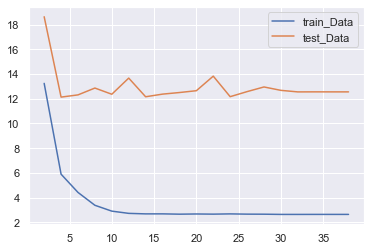

In [55]:
from sklearn.metrics import confusion_matrix
train_plot=pd.DataFrame(train_error,index=range(2,40,2),columns=["train_Data"])
test_plot=pd.DataFrame(test_error,index=range(2,40,2),columns=["test_Data"])
plotdata=pd.concat([train_plot,test_plot],axis=1)
plotdata.plot()
X_test.size

In [56]:
y_test.head()

DateTime
2020-08-10    54.968586
2020-08-11    57.741318
2020-08-12    56.753124
2020-08-13    59.927811
2020-08-14    63.826542
Name: PriceClose2D, dtype: float64

# Model 2: ARIMA MODEL :

In [57]:
arima2015hour=coinbase['2015':'2020'].resample('D').mean().fillna(method='ffill')['Close']


In [59]:
from statsmodels.tsa.stattools import adfuller
adfuller(arima2015hour)[1]

0.0700900655333895

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
train,test = train_test_split(arima2015hour,test_size=0.24,shuffle=False)
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(arima2015hour, order=(4, 4))
result = mod.fit()

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARMA(history,order=(5,1))
    model_fit = mod.fit()
    yhat = model_fit.forecast()
    yhat_p = model_fit.predict(start=len(history), end=len(history))[0]
    predictions.append(yhat_p)
    # observation
    obs = test[i] 
    history.append(obs)
    print(str(yhat_p)+' '+' '+ str(history[-4:])+' '+str(obs)+' '+str(i)+' ')


91.64326880423067  [99.627586, 95.417389, 90.622627, 94.309669] 94.309669 0 
91.91331665758386  [95.417389, 90.622627, 94.309669, 93.44632] 93.44632 1 
94.298445180487  [90.622627, 94.309669, 93.44632, 94.305016] 94.305016 2 
94.62489056637247  [94.309669, 93.44632, 94.305016, 88.889023] 88.889023 3 
86.23152783018784  [93.44632, 94.305016, 88.889023, 89.76933299999997] 89.76933299999997 4 
91.72200974783732  [94.305016, 88.889023, 89.76933299999997, 90.426422] 90.426422 5 
89.18084205134268  [88.889023, 89.76933299999997, 90.426422, 90.566948] 90.566948 6 
89.3828470189075  [89.76933299999997, 90.426422, 90.566948, 98.509575] 98.509575 7 
100.98126563503742  [90.426422, 90.566948, 98.509575, 99.179726] 99.179726 8 
96.80268680376547  [90.566948, 98.509575, 99.179726, 94.941292] 94.941292 9 
95.14744485770584  [98.509575, 99.179726, 94.941292, 94.580879] 94.580879 10 
95.75435870955245  [99.179726, 94.941292, 94.580879, 93.203781] 93.203781 11 
90.42644409310108  [94.941292, 94.580879,

In [61]:
pd.concat([pd.DataFrame(predictions,index=test.index,columns=['predictions']),test],axis=1)

,predictions,Close
DateTime,,
2019-07-24,91.643269,94.309669
2019-07-25,91.913317,93.446320
2019-07-26,94.298445,94.305016
2019-07-27,94.624891,88.889023
2019-07-28,86.231528,89.769333
...,...,...
2020-12-27,128.901106,127.516968
2020-12-28,130.039150,130.050339
2020-12-29,127.515765,129.040802


In [62]:
error=math.sqrt(mean_squared_error(test,predictions))
error

3.079525142425191

In [63]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(arima2015hour, order=(4,4))
result = mod.fit()

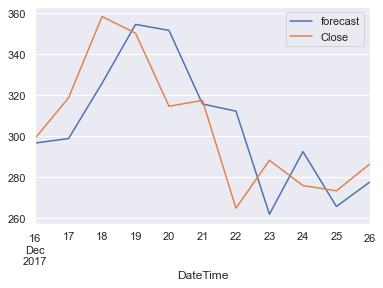

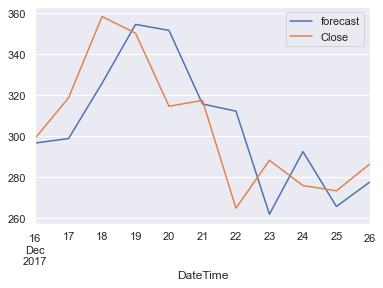

In [64]:
result.plot_predict(start=1080,end=1090)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2192
Model:                     ARMA(4, 4)   Log Likelihood               -6710.378
Method:                       css-mle   S.D. of innovations              5.161
Date:                Mon, 26 Apr 2021   AIC                          13440.756
Time:                        21:53:54   BIC                          13497.681
Sample:                    01-01-2015   HQIC                         13461.561
                         - 12-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          49.7965     18.490      2.693      0.007      13.557      86.036
ar.L1.Close     0.5816      0.093      6.271      0.000       0.400       0.763
ar.L2.Close     0.5013      0.030     16.753    

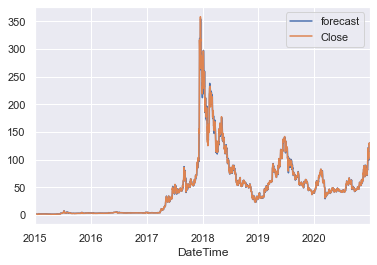

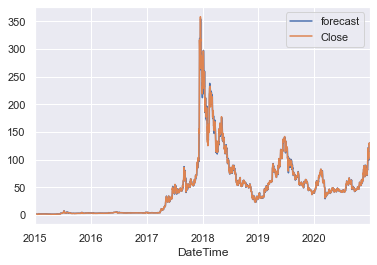

In [65]:
print(result.summary())
result.plot_predict()

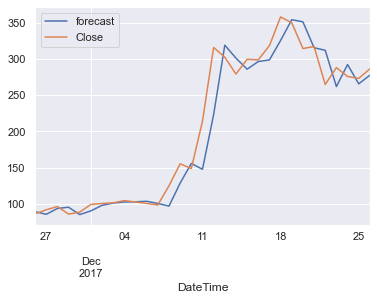

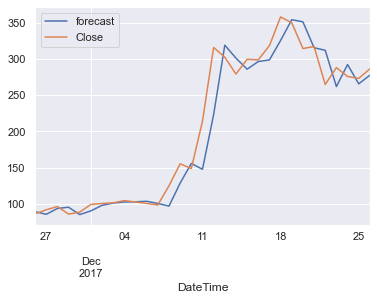

In [66]:
result.plot_predict(start=1060, end=1090)

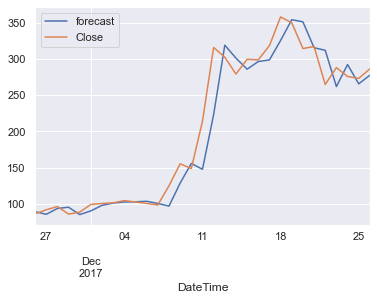

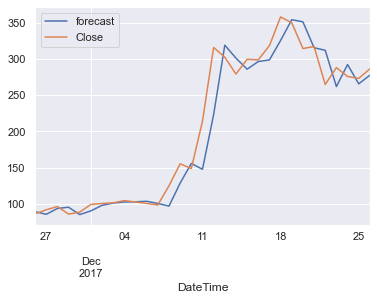

In [67]:
result.plot_predict(start=1060, end=1090)